<a href="https://colab.research.google.com/github/JakobRobnik/MicroCanonicalHMC/blob/master/Ensamble_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ensamble MCHMC tutorial: sampling from the Rosenbrock function**

We will sample from a common benchmark problem: the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function).
In its original form, the Rosenbrock function is a two-dimensional function with a narrow banana shape:

$f(x, y) = (a- x)^2 + b (y - x^2)^2$. 

The width is controled by the parameter b. Let's define the function:

In [1]:
import jax
import jax.numpy as jnp

a, b = 1.0, 10.0

f = lambda x, y: jnp.square(a - x) + b * jnp.square(y - jnp.square(x)) #rosenbrock function

We will sample from the distribution $p(x, y) \propto \exp{ -\frac{1}{2} f(x, y)}$.

Let's visualize it:

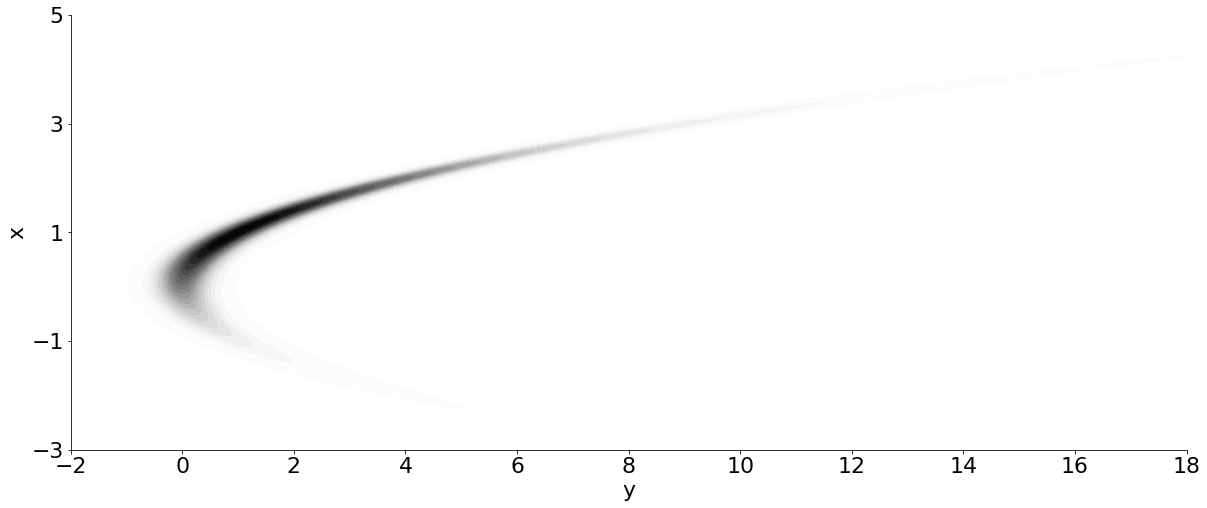

In [4]:
import matplotlib.pyplot as plt
import numpy as np

xmin, xmax = -3, 5
ymin, ymax = -2, 18
xlin= jnp.linspace(xmin, xmax, 300)
ylin= jnp.linspace(ymin, ymax, 300)
X, Y = jnp.meshgrid(xlin, ylin)
Z = f(X, Y)


# figure setup
plt.rcParams.update({'font.size': 22, 'axes.spines.right': False, 'axes.spines.top': False})
plt.figure(figsize = (ymax-ymin, xmax-xmin))

levels = np.linspace(0.005, 1, 20)
plt.contourf(Y, X, jnp.exp(-0.5*Z), cmap = 'Greys', levels = levels)
plt.xlabel('y')
plt.ylabel('x')
plt.xticks(np.arange(ymin, ymax+1, 2))
plt.yticks(np.arange(xmin, xmax+1, 2))
plt.show()

We will make the problem more interesting and take a cartesian product of 18 Rosenbrock distributions:
$p(x_1,\, x_2,\, \ldots x_{18},\, y_1,\, y_2,\, \ldots y_{18}) = p(x_1,\, y_1) \cdot p(x_2,\, y_2) \cdots p(x_{18},\, y_{18})$

In [5]:
d = 2 * 18

def nlogp(xy):
    """- log(p) of our target distribution"""
    x = xy[:18]
    y = xy[18:]
    return 0.5 * jnp.sum(f(x, y))

Let's import the MCHMC code:

In [ ]:
!git clone https://github.com/JakobRobnik/MicroCanonicalHMC.git

and create the target class. The obligatory attributes are the configuration space dimension `d` and a function `grad_nlogp` which returns the negative log density and its gradient. We will use the auto-diff to get the gradient.

In [7]:
from MicroCanonicalHMC.sampling.ensamble import Sampler


class RosenbrockTarget():

    def __init__(self):

        self.d = d
        self.grad_nlogp = jax.value_and_grad(nlogp) #auto-diff

    def prior_draw(self, key):
        """gaussian prior"""
        return jax.random.normal(key, shape = (self.d, ), dtype = 'float64')*3.0


We have also defined the ```prior_draw``` which can be used to initialize the particles. 

In [8]:
num_chains = 300 # we will run 300 chains
random_seed = jax.random.PRNGKey(42)
sampler = Sampler(RosenbrockTarget(), alpha = 10.0) # alpha = 1.0 is more universal, but specifically for the Rosenbrock, the convergence is faster with alpha = 10.

If we have 300 devices available we can run each particle on its own device by passing an additional argument `pmap = True` to the Sampler.

Initially the particles are far from the target distribution:


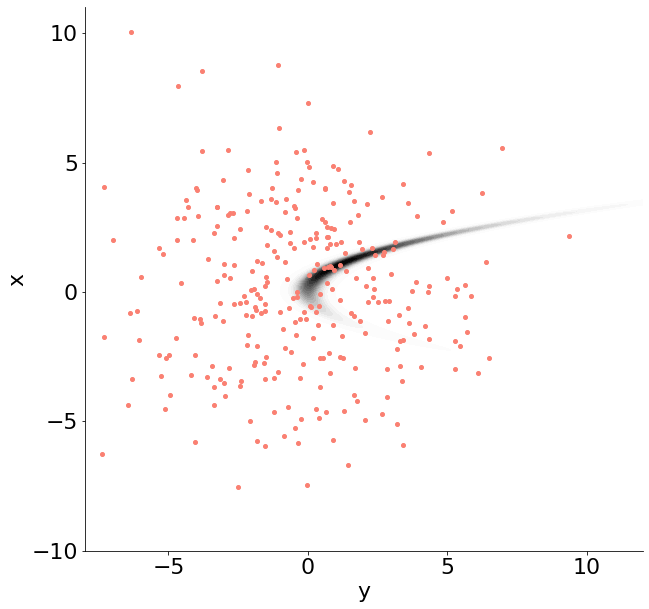

In [26]:
#draw from the prior
x_initial = sampler.Target.prior_draw(jax.random.split(random_seed, num_chains))

plt.figure(figsize = (10, 10))

#plot the intial particle locations
plt.plot(x_initial[:, 0], x_initial[:, 1], '.', markersize = 8, color = 'salmon') 

#target distribution
plt.contourf(Y, X, jnp.exp(-0.5*Z), cmap = 'Greys', levels = levels)

plt.xlabel('y')
plt.ylabel('x')
plt.xlim(-8, 12)
plt.ylim(-9, 11)
plt.xticks([-5, 0, 5, 10])
plt.yticks([-10, -5, 0, 5, 10])
plt.show()

We will run the sampler for 500 steps and automatically remove the burn-in:

In [ ]:
samples = sampler.sample(num_steps = 500, num_chains= num_chains, remove_burn_in = True)

The output has the shape `(num_chains, num_samples - burn_in, d)`:

In [20]:
samples.shape

(300, 369, 36)

Let's visualize the 2d posteriors in the $(x_1,\, y_1)$ plane. We show the end positions of the particles with dots. The 2d posterior histogram, using all of the $300 \cdot 369$ samples is shown as a color plot. The ground truth levels are white.

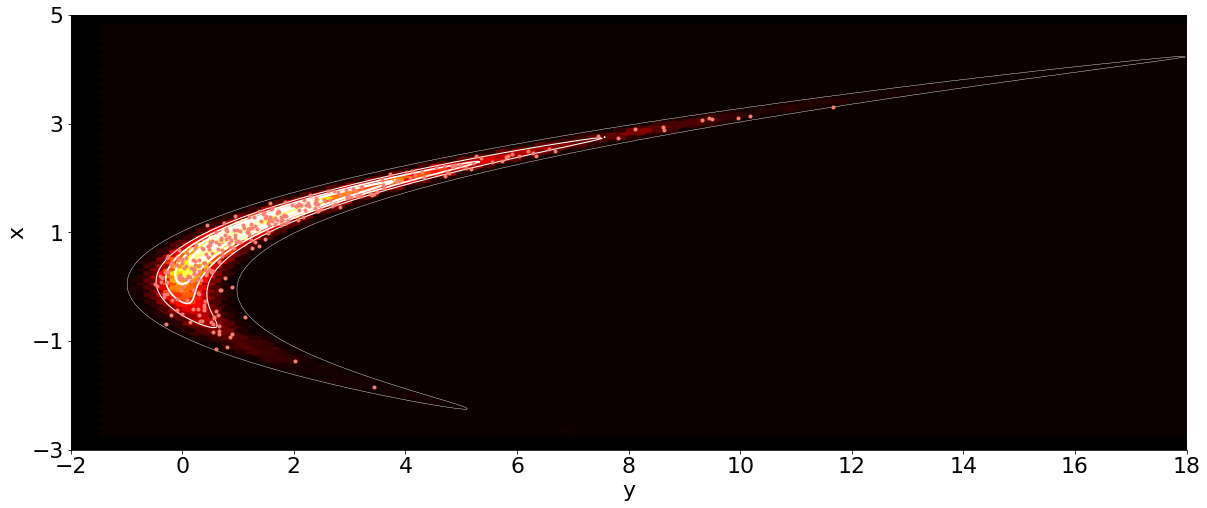

In [22]:
plt.figure(figsize = (ymax-ymin, xmax-xmin))

# the end positions of the chains
x, y = samples[:, -1, 0], samples[:, -1, 18]
plt.plot(y, x, '.', color = 'salmon') 


# 2d histrogram using all of the samples
x1_samples = jnp.concatenate(samples[:, :, 0])
y1_samples = jnp.concatenate(samples[:, :, 18])
plt.hexbin(y1_samples, x1_samples, cmap='hot', gridsize=100) 
plt.gca().set_facecolor('black')


# ground truth levels
plt.contour(Y, X, jnp.exp(-0.5*Z), colors = 'white', linewidths = np.linspace(0.4, 3, 5), levels = levels[::4]) #ground truth levels

plt.xlabel('y')
plt.ylabel('x')
plt.xticks(np.arange(ymin, ymax+1, 2))
plt.yticks(np.arange(xmin, xmax+1, 2))
plt.xlim(ymin, ymax)
plt.ylim(xmin, xmax)
plt.show()